# Informe nº5
    Notas: breve actualización del TFG. Modificación de los métodos teniendo en cuenta los comentarios de los tutores.
    Fecha: 27/06/2020
   
   ### Convenios para el cálculo de la intensidad de un pixel
    Se definen los tres tipos de convenios que existes para calcular la intesidad percibida en un pixel.
    
   ### Coseno cenital      
    Se modifica la forma de cálculo de la intensidad media mediante la introducción del factor coseno del ángulo cenital. 

   ### Corrección gamma
    Aplicación de la corrección por factor gamma, con la que se obtiene, de froma teórica, la radiación percibida por el pixel.

   ### Correlación de las medidas obtenidas con la radiación difusa
    Se expone la matriz de correlación de las medidas obtenidas y la radiación difusa medida.

In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install pvlib
!pip install pyephem
!pip install pandas
!pip install datetime
!pip install sklearn

import cv2
import numpy as np
import pandas as pd
import datetime as dt
import math
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pvlib as pv
from datetime import datetime as dt
from glob import glob

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

from mascaras import *
from funciones_algoritmo import *
from muestra_imagenes import *

   ### Convenios para el cálculo de la intensidad de un pixel
    Existen distintos convenios para determinar la intensidad, o luminosidad, de un píxel. Debido a nuestra forma de perciir los colores, la intensidad media de un pixel no es simplemnete la media entre los tres colores principales, RGB. Sino que se realiza una suma ponderada. Dos de estos convenios son:
   + CCIR 601: este convenio se creó en los años 80, con lo que resulta un poco anticuado. Resulta útil en casos en los que se trabaje con imágenes analógicas. En este convenio, el peso de los colores es: 0.299, el rojo, 0.587, el verde, y 0.114, el azul.
   + ITUR 709: este convenio es más actual que el anterior, ademá, se encuentra actualizado para las imágenes digtales. El peso de los colores es: 0.2126, el rojo, 0.7152, el verde, y 0.0722, el azul.

In [2]:
# Código para el cálculo de las intensidad con los distintos métodos
def intensidad_media_no_ponderada(img_bgr):
    # Cálculo de la luminancia del pixeles,
    # como media de los canales B, G y R
    
    B = img_bgr[:,:,0]
    G = img_bgr[:,:,1]
    R = img_bgr[:,:,2]
    
    I = np.array(B/3 + G/3 + R/3, np.uint8)
    return I

    
def intensidad_media_CCIR(img_bgr):
    # Basado en el convenio CCIr 601 para el cáluclo de 
    # luminancia en imágenes analógicas
    
    B = img_bgr[:,:,0]
    G = img_bgr[:,:,1]
    R = img_bgr[:,:,2]

    I = np.array(B * 0.114 + G * 0.587 + R * 0.299, np.uint8)
    return I 
    
def intensidad_media_ITUR(img_bgr):
    # Basado en el convenio ITU-R BT 709 para el cáluclo de 
    # luminancia en imágenes digitales
    
    B = img_bgr[:,:,0]
    G = img_bgr[:,:,1]
    R = img_bgr[:,:,2]

    I = np.array(B * 0.0722 + G * 0.7152 + R * 0.2126, np.uint8)
    return I 

   ### Coseno cenital
    Por la recomendación de uno de los tutores, para realizar el cálculo de la intensidad media se ha multiplicado los valores obtenidos en cada pixel por el coseno del ángulo cenital en el que se encuentran. Esto surge de la idea en la que la radiación detectada por el piranómetros es dependiende del ángulo de incidencia de los rayos solares. Debido a que el zenit representa el ángulo que forma el sol con la horizontal, el coseno de este ángulo afecta a la radiación percibida.

   ### Corrección gamma
    Mediante la corrección gamma se realiza la tranformación de una magnitud física, radiación percibida en el sensores, a una magnitud digital, rango de 0 a 255. Esta corrección se realiza de forma automatíca por los circuitos de control de las cámaras. Teóricamente, podemos aplicar la función inversa al valor del píxel, para obtener la radiación percibida en cada sensor/píxel. 
    Esta correción se basa en elevar el valor percibido en un factor gamma, normalmente 2.2 en cámaras digitales. Por lo tanto, para obtener la radiación percibida, hay que elevar a la inversa de gamma el valor del píxel en cuestión.

In [3]:
def gamma_corr(img_bgr, gamma=2.2, maxVal=255):         
    gamma_inv = 1.0 / gamma
    img_norm = img_bgr / maxVal
    img_corr = np.power(img_norm, gamma_inv) * maxVal

    return img_corr

   ### Combinación de los métodos
    Se han obtenido todas las posibles combinaciones de los métodos expuestos anteriormente, con el fin de obtener la combinación que mejor se relacione con las radiacion difusa medida. Para ello se expone a continuación la función que se encarga de gestionar la selección de los métodos.

In [4]:
def intensidad_media(img_bgr, mask=None, modo='ITUR', coseno=False, gamma=None):
    # Función para el cálculo de la intensidad media por varios métodos
    
    modos = {'No ponderado': intensidad_media_no_ponderada,
            'CCIR': intensidad_media_CCIR,
            'ITUR': intensidad_media_ITUR}
            
    # Corrección gamma
    if gamma != None:
        img_bgr = gamma_corr(img_bgr, gamma)
    
    # Aplicación del método deseado
    I = modos[modo](img_bgr)
    
    # Aplicación del coseno a las intensidades
    if coseno:
        zenits = matriz_posiciones()[:,:,0]
        I = np.multiply(I, np.cos(np.deg2rad(zenits)))
        
    
    # Se obtiene el valor medio de la intensidad de la imagen
    media = cv2.mean(I, mask)[0]
    
    return media

   ### Correlación de las medidas obtenidas con la radiación difusa
    A continuación, se ha obtenido la matriz de correlación de las medidas obtenidas. Esta matriz nos permite hacernos una idea de la relación que existe entre las medidas obtenidas y la radiación difusa obtenida.
    
    A continuación se exponen la nomenclatura utilizada para representar los datos obtenidos por cada método. De forma similar a los anteriores informes, se raliza una distinción entre el tipo de píxel, diferenciando entre píxel perteneciente a nube o a cielo despejado. Acto seguido en el nombre se indica el método usado para el cálculo de la intensidad media, No ponderado, CCIR(imágenes analógias) o ITUR(imágenes digitales), seguido de un indicativo que representa si se ha aplicado el coseno del ángulo cenital del píxel y de la corrección gamma.

    Por ejemplo, si queremos obtener la intensidad media de los píxeles de nubes, utilizando el método para imágenes analógicas, CCIR, aplicando el coseno cenital y sin la corrección gamma, deberemos buscar en la lista: "Intesidad nubes CCIR Coseno:True Gamma_corr:False"

   #### Cielo nublado

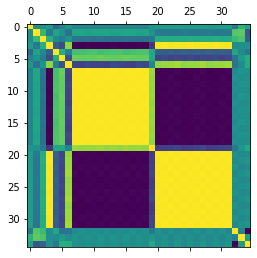

In [5]:
pd_info_regresion_nublado = pd.read_csv('Datos/info_regresion_nublado_completo.csv')

# Matrices de correlación
Corr_matrix = pd_info_regresion_nublado.corr()

plt.matshow(Corr_matrix)
plt.show()

In [6]:
# Correlación entre las medidas y la radiación difusa para cielos nublados
Corr_matrix[['Radiacion difusa']]

,Radiacion difusa
Unnamed: 0,-0.007941
Radiacion,0.331315
Radiacion difusa,1.000000
Ratio nubes,0.251099
Factor solar,-0.043930
Área solar,-0.161828
Intensidad cielo,0.035335
Intensidad cielo No ponderado Coseno:True Gamma_corr:True,-0.240198
Intensidad cielo No ponderado Coseno:False Gamma_corr:True,-0.255891
Intensidad cielo No ponderado Coseno:True Gamma_corr:False,-0.250954


Observmoas que en los cielos nublados la relación de la radiación difusa es mayor con las intensidades de las nubes. La mayor correlación es presentada por los cálculos realizados con la corrección gamma y sin aplicar el coseno cenital, independientemente del convenio utilizado para el cálculo de la intensidad. Además, existe gran relación con la radiación global  horizontal teórica, "ghi", y la radiación global real medida por los sensores, "Radiación".

   #### Cielo despejado

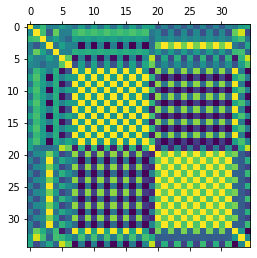

In [7]:
pd_info_regresion_despejado = pd.read_csv('Datos/info_regresion_despejado_completo.csv')

# Matrices de correlación
Corr_matrix = pd_info_regresion_despejado.corr()

plt.matshow(Corr_matrix)
plt.show()

In [8]:
# Correlación entre las medidas y la radiación difusa para cielos despejados
Corr_matrix[['Radiacion difusa']]

,Radiacion difusa
Unnamed: 0,0.330802
Radiacion,0.393517
Radiacion difusa,1.000000
Ratio nubes,-0.091900
Factor solar,0.147383
Área solar,-0.143878
Intensidad cielo,-0.320582
Intensidad cielo No ponderado Coseno:True Gamma_corr:True,0.146463
Intensidad cielo No ponderado Coseno:False Gamma_corr:True,0.074988
Intensidad cielo No ponderado Coseno:True Gamma_corr:False,0.145981


En los cielos despejados la mayor correlación se presenta con las intensidades de la parte de cielo libre de nubes. Mayor en los casos en los que se aplica el coseno cenital, disminuyendo drásticamente en los otros casos. Además, como sucede en los cielos nublados, existe gran relación con la radiación global  horizontal teórica, "ghi", y la radiación global real medida por los sensores, "Radiación".

A continuación, se representan las estimaciones con las variables que presentan una mayor correlación:

   #### Cielo nublado lineal

In [9]:
lista_medidas_nublado = ['Radiacion', 'Ratio nubes', 'Intensidad nubes ITUR Coseno:False Gamma_corr:True']

pd_info_regresion_nublado = pd.read_csv('Datos/info_regresion_nublado_completo.csv')
y_rad_nublado = pd_info_regresion_nublado['Radiacion difusa']
x_rad_nublado = pd_info_regresion_nublado[lista_medidas_nublado]

# Se leen los datos utilziados para el test
pd_info_regresion_test_nublado = pd.read_csv('Datos/info_regresion_test_nublado_completo.csv')

x_rad_test_nublado = pd_info_regresion_test_nublado[lista_medidas_nublado]

In [10]:
# Modelo de regresión lineal normal
reg = LinearRegression()
reg.fit(x_rad_nublado, y_rad_nublado)

score = reg.score(x_rad_nublado, y_rad_nublado)
print('El coeficiente de determinación, R2, es {:.2f}.'.format(score))

El coeficiente de determinación, R2, es 0.21.


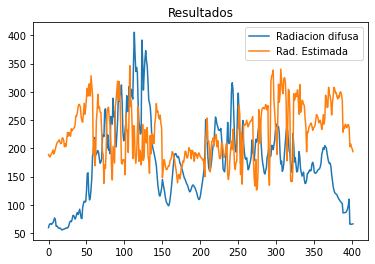

In [11]:
# Se realiza la predicción con los parámetros de test
predicted_rad = []
for i in range(len(pd_info_regresion_test_nublado)):
    predicted_rad.append(reg.predict([x_rad_test_nublado.iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion_test_nublado
pd_predicted['Rad. Estimada'] = predicted_rad

pd_predicted['Radiacion difusa'].plot(title='Resultados', legend=True)
pd_predicted['Rad. Estimada'].plot(legend=True)

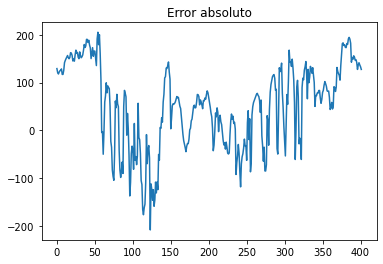

In [12]:
errores = pd_predicted['Rad. Estimada'] - pd_predicted['Radiacion difusa']
errores.plot(title='Error absoluto', legend=False)

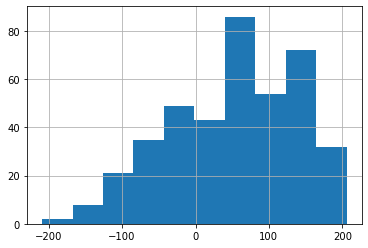

In [13]:
errores.hist()

In [14]:
RMSE = mean_squared_error(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'], squared=False)
expl_var = explained_variance_score(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'])

print('El RMSE es {:.2f}.'.format(RMSE))
print('La puntuación de varianza explicada es {:.2f}.'.format(expl_var))

El RMSE es 101.14.
La puntuación de varianza explicada es -0.54.


   #### Cielo despejado lineal

In [15]:
lista_medidas_despejado = ['Radiacion', 'Intensidad cielo ITUR Coseno:True Gamma_corr:True']

pd_info_regresion_despejado = pd.read_csv('Datos/info_regresion_despejado_completo.csv')
y_rad_despejado = pd_info_regresion_despejado['Radiacion difusa']
x_rad_despejado = pd_info_regresion_despejado[lista_medidas_despejado]

# Se leen los datos utilziados para el test
pd_info_regresion_test_despejado = pd.read_csv('Datos/info_regresion_test_despejado_completo.csv')
x_rad_test_despejado = pd_info_regresion_test_despejado[lista_medidas_despejado]

In [16]:
# Modelo de regresión lineal normal
reg = LinearRegression()
reg.fit(x_rad_despejado, y_rad_despejado)

score = reg.score(x_rad_despejado, y_rad_despejado)
print('El coeficiente de determinación, R2, es {:.2f}.'.format(score))

El coeficiente de determinación, R2, es 0.16.


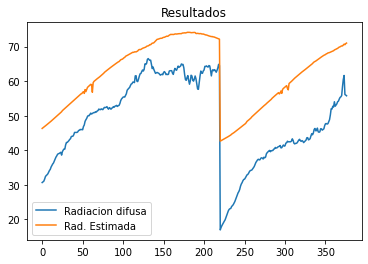

In [17]:
# Se realiza la predicción con los parámetros de test
predicted_rad = []
for i in range(len(pd_info_regresion_test_despejado)):
    predicted_rad.append(reg.predict([x_rad_test_despejado.iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion_test_despejado
pd_predicted['Rad. Estimada'] = predicted_rad

pd_predicted['Radiacion difusa'].plot(title='Resultados', legend=True)
pd_predicted['Rad. Estimada'].plot(legend=True)

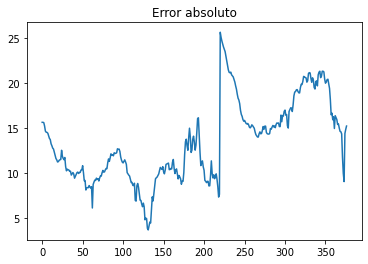

In [18]:
errores = pd_predicted['Rad. Estimada'] - pd_predicted['Radiacion difusa']
errores.plot(title='Error absoluto', legend=False)

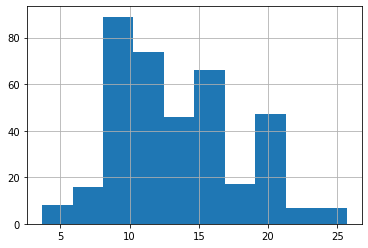

In [19]:
errores.hist()

In [20]:
RMSE = mean_squared_error(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'], squared=False)
expl_var = explained_variance_score(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'])

print('El RMSE es {:.2f}.'.format(RMSE))
print('La puntuación de varianza explicada es {:.2f}.'.format(expl_var))

El RMSE es 14.15.
La puntuación de varianza explicada es 0.86.


   #### Cielo nublado polinómico

In [21]:
grados = 3
model = Pipeline([('poly', PolynomialFeatures(degree=grados)),
                  ('linear', LinearRegression())])
model = model.fit(x_rad_nublado, y_rad_nublado)

score = model.score(x_rad_nublado, y_rad_nublado)
print('El coeficiente de determinación, R2, es {:.2f}.'.format(score))

El coeficiente de determinación, R2, es 0.65.


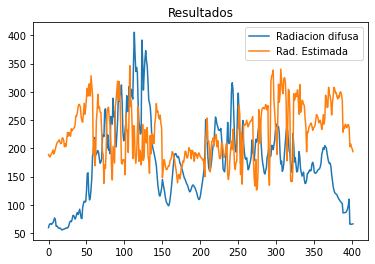

In [22]:
# Se realiza la predicción con los parámetros de test
predicted_rad = []
for i in range(len(pd_info_regresion_test_nublado)):
    predicted_rad.append(model.predict([x_rad_test_nublado.iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion_test_nublado
pd_predicted['Rad. Predecida'] = predicted_rad

pd_predicted['Radiacion difusa'].plot(title='Resultados', legend=True)
pd_predicted['Rad. Estimada'].plot(legend=True)

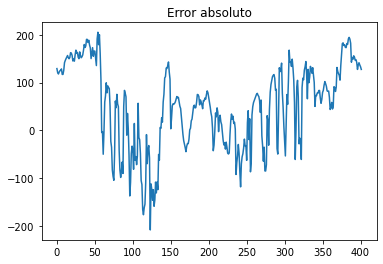

In [23]:
errores = pd_predicted['Rad. Estimada'] - pd_predicted['Radiacion difusa']
errores.plot(title='Error absoluto', legend=False)

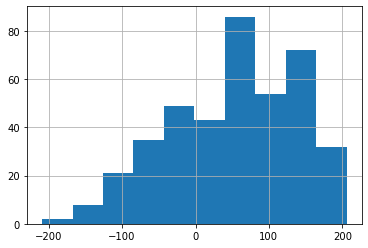

In [24]:
errores.hist()

In [25]:
RMSE = mean_squared_error(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'], squared=False)
expl_var = explained_variance_score(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'])

print('El RMSE es {:.2f}.'.format(RMSE))
print('La puntuación de varianza explicada es {:.2f}.'.format(expl_var))

El RMSE es 101.14.
La puntuación de varianza explicada es -0.54.


   #### Cielo despejado polinómico

In [26]:
grados = 2
model = Pipeline([('poly', PolynomialFeatures(degree=grados)),
                  ('linear', LinearRegression())])
model = model.fit(x_rad_despejado, y_rad_despejado)

score = model.score(x_rad_despejado, y_rad_despejado)
print('El coeficiente de determinación, R2, es {:.2f}.'.format(score))

El coeficiente de determinación, R2, es 0.23.


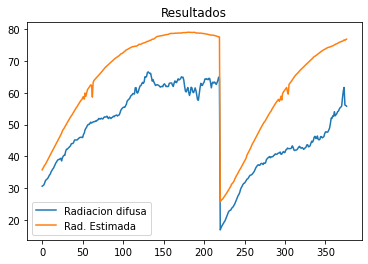

In [27]:
# Se realiza la predicción con los parámetros de test
predicted_rad = []
for i in range(len(pd_info_regresion_test_despejado)):
    predicted_rad.append(model.predict([x_rad_test_despejado.iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion_test_despejado
pd_predicted['Rad. Estimada'] = predicted_rad

pd_predicted['Radiacion difusa'].plot(title='Resultados', legend=True)
pd_predicted['Rad. Estimada'].plot(legend=True)

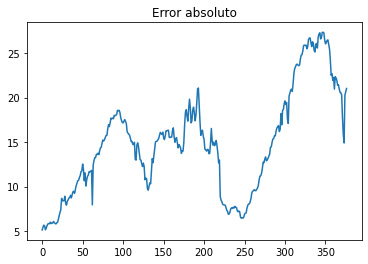

In [28]:
errores = pd_predicted['Rad. Estimada'] - pd_predicted['Radiacion difusa']
errores.plot(title='Error absoluto', legend=False)

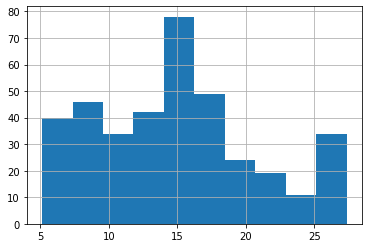

In [29]:
errores.hist()

In [30]:
RMSE = mean_squared_error(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'], squared=False)
expl_var = explained_variance_score(pd_predicted['Radiacion difusa'], pd_predicted['Rad. Estimada'])

print('El RMSE es {:.2f}.'.format(RMSE))
print('La puntuación de varianza explicada es {:.2f}.'.format(expl_var))

El RMSE es 15.96.
La puntuación de varianza explicada es 0.77.


   ### Resultados y consulsiones
+ Podemos observar que los resulatdos obtenidos en cielos despejados son aceptables, esto se debe a que la relación entre radiación global medida y difusa se mantiene practicamente constante. Con lo que, utilizado este parámetro y añadiendo las medidas obtenidas de la imágenes podemos obtener un modelo con cierta similitud a la realidad. Con este método obtenemos un RMSE de 15 W/m2 en ambos modelos, lineal y polinómico, con puntuaciones de varianza explicada altas en ambos casos.
+ Por otro lado, para cielos nublados los resultados son mediocres, vemos que se mantiene la tendendia en el modelo realizado, pero los resultados obtenidos tienen error relativamente elevado. En este modelo observamos un RMSE de 100 W/m2, un valor alto comparado con el modelo de cielo despejado, aunque en este tipo de cielo observamos una mayor radiación difusa. Se continuará trabajando en un modelo para este tipos de cielos que se aproxime más a la realidad.

   ### Comentarios 
    Para más informacion sobre los dos convenios para el cálculo de la intensidad de un píxel y la corrección gamma, consultar la sección de 12.2.1 "Conversion to Grayscale" y 4.7 "Gamma Correction", en el libro de Springer "Digital Image Processing".
    
    Los datos para los test corresponden a los días 13, 14, 16, 17 y 23 de junio para cielos nublados y de los días 20 y 28 de junio para los cielos despejados.